In [1]:
cd /home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/

/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster


/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install torchinfo

In [3]:
from dataclasses import dataclass
import json
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torchinfo
import vak

import framenets  # so parsing configs doesn't fail

/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
results_root = pathlib.Path('results/multiclass/BFSongRepo/')

In [5]:
@dataclass
class ModelMetadata:
    """Class that represents a trained model + metadata"""
    results_dir: str
    window_size: int
    loss: str
    hyperparameters: str | None = None
    trainable_params: int = 0

In [6]:
COLUMNS = [
    'model_name', 'dataset', 'train_dur', 'replicate_num', 'window_size', 'loss', 'trainable_params',
    'avg_val_acc_epoch', 'avg_val_acc_tfm_epoch', 
    'avg_val_levenshtein_epoch', 'avg_val_levenshtein_tfm_epoch', 
    'avg_val_loss_epoch',
    'avg_val_character_error_rate_epoch', 'avg_val_character_error_rate_tfm_epoch',
    'avg_val_precision_epoch', 'avg_val_precision_tfm_epoch',
    'avg_val_recall_epoch', 'avg_val_recall_tfm_epoch',
    'avg_val_fscore_epoch', 'avg_val_fscore_tfm_epoch',
]


def df_from_model_metadata_map(model_metadata_map: dict) -> pd.DataFrame:
    results_df = []

    for model_name, metadata in model_metadata_map.items():
        csv_path = results_root / 'all-birds' / model_name / metadata.results_dir / 'learning_curve.csv'
        df = pd.read_csv(csv_path)
        df['dataset'] = 'all-birds'
        df['window_size'] = metadata.window_size
        df['loss'] = metadata.loss
        df['trainable_params'] = metadata.trainable_params
        df = df[COLUMNS]
        results_df.append(df)

    results_df = pd.concat(results_df)

    columns = {
        column_old: column_old.replace('avg_val_', '').replace('_epoch', '') 
        if column_old.startswith('avg_val') else column_old
        for column_old in results_df.columns
    }
    columns.update(
        {
            'model_name': 'Model',
            'window_size': 'Window Size',
            'hyperparameters': 'Hyperparameters',
            'train_dur': 'Training set size (s)',
            'loss': 'Loss',
            'trainable_params': 'Trainable Params (M)',
        }
    )
    results_df = results_df.rename(columns=columns)

    results_df['frame_error'] = (1.0 - results_df['acc']) * 100
    results_df['frame_error_tfm'] = (1.0 - results_df['acc_tfm']) * 100
    for metric_name in (
        'character_error_rate',
        'character_error_rate_tfm',
        'precision',
        'precision_tfm',
        'recall',
        'recall_tfm',
        'fscore',
        'fscore_tfm',
    ):
        results_df[metric_name] = results_df[metric_name] * 100

    return results_df

In [7]:
MODEL_METADATA_MAP = {
    'TweetyNet': ModelMetadata(
        results_dir='results_231025_222720',
        window_size=2000,
        loss='CE',
    ),
    'TemporalConvNet': ModelMetadata(
        results_dir='results_231026_103215',
        window_size=2000,
        loss='CE',
    ),
    'ConvTemporalConvNet': ModelMetadata(
        results_dir='results_231025_222812',
        window_size=2000,
        loss='CE'
    ),
}

In [8]:
PROJ_ROOT = pathlib.Path('/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/')
RESULTS_ROOT = PROJ_ROOT / 'results/multiclass/BFSongRepo/all-birds/'

In [9]:
records = []

for net_name, metadata in MODEL_METADATA_MAP.items():
    results_dir = RESULTS_ROOT / net_name / metadata.results_dir
    toml_path = sorted(results_dir.glob('*toml'))[0]
    cfg = vak.config.parse.from_toml_path(toml_path)

    model_name = cfg.learncurve.model
    model_config = vak.config.model.config_from_toml_path(toml_path, model_name)

    dataset_path = PROJ_ROOT / cfg.learncurve.dataset_path

    item_transform = vak.transforms.defaults.get_default_transform(
        model_name, "eval", cfg.learncurve.val_transform_params
    )
    val_dataset = vak.datasets.frame_classification.FramesDataset.from_dataset_path(
        dataset_path=dataset_path,
        split="test",
        item_transform=item_transform
    )
    input_shape = val_dataset.shape

    labelmap_path = dataset_path / 'labelmap.json'
    with labelmap_path.open('r') as fp:
        labelmap = json.load(fp)
    
    model = vak.models.get(
        model_name,
        model_config,
        num_classes=len(labelmap),
        input_shape=input_shape,
        labelmap=labelmap,
    )

    ckpts = sorted(results_dir.glob(
        f'train_dur_*s/replicate_*/{net_name}/checkpoints/*pt'
    ))
    for ckpt in ckpts[:1]:
        model.load_state_dict_from_path(ckpt)
        summary = torchinfo.summary(model, input_size=(1, 1, 257, 1000))
    MODEL_METADATA_MAP[model_name].trainable_params = summary.trainable_params

/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [10]:
results_dir.exists()

True

In [11]:
data = df_from_model_metadata_map(MODEL_METADATA_MAP)

data = data.drop(columns='dataset')

id_vars = [
    'Model',
    'replicate_num',
    'Trainable Params (M)',
    
]

value_vars = [
    'character_error_rate',
    'character_error_rate_tfm',
    'precision',
    'precision_tfm',
    'recall',
    'recall_tfm',
    'fscore',
    'fscore_tfm',
    'frame_error',
    'frame_error_tfm'
]

data = data.melt(id_vars=id_vars, value_vars=value_vars)

data['Post-processing'] = data['variable'].apply(lambda x: x.endswith('_tfm'))

var_metric_map = dict(zip((
    'frame_error',
    'frame_error_tfm',
    'character_error_rate',
    'character_error_rate_tfm',
    'precision',
    'precision_tfm',
    'recall',
    'recall_tfm',
    'fscore',
    'fscore_tfm',
),
(
    'Frame Error (%)',
    'Frame Error (%)',
    'Character Error Rate (%)',
    'Character Error Rate (%)',
    'Precision (%)',
    'Precision (%)',
    'Recall (%)',
    'Recall (%)',
    '$F$-score (%)',
    '$F$-score (%)',
)))

data['Metric'] = data['variable'].map(var_metric_map)

In [12]:
@dataclass
class MetricPlot:
    metric: str
    ascending: bool
    ylim: list[int]
    save_fname: str
    legend_loc: str

In [13]:
metrics_plots = (
    MetricPlot(
        metric='Frame Error (%)',
        ascending=True,
        ylim=[0., 2.5],
        save_fname='trainable-params-frame-error',
        legend_loc='upper left',
    ),
    MetricPlot(
        metric='Character Error Rate (%)',
        ascending=True,
        ylim=[0., 35.],
        save_fname='trainable-params-character-error-rate',
        legend_loc='upper left',
    ),
    MetricPlot(
        metric='Precision (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='trainable-params-precision',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='Recall (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='trainable-params-recall',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='$F$-score (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='trainable-params-fscore',
        legend_loc='lower right',
    ),
)

In [14]:
sns.set()
sns.set_context('poster', font_scale=1.5)

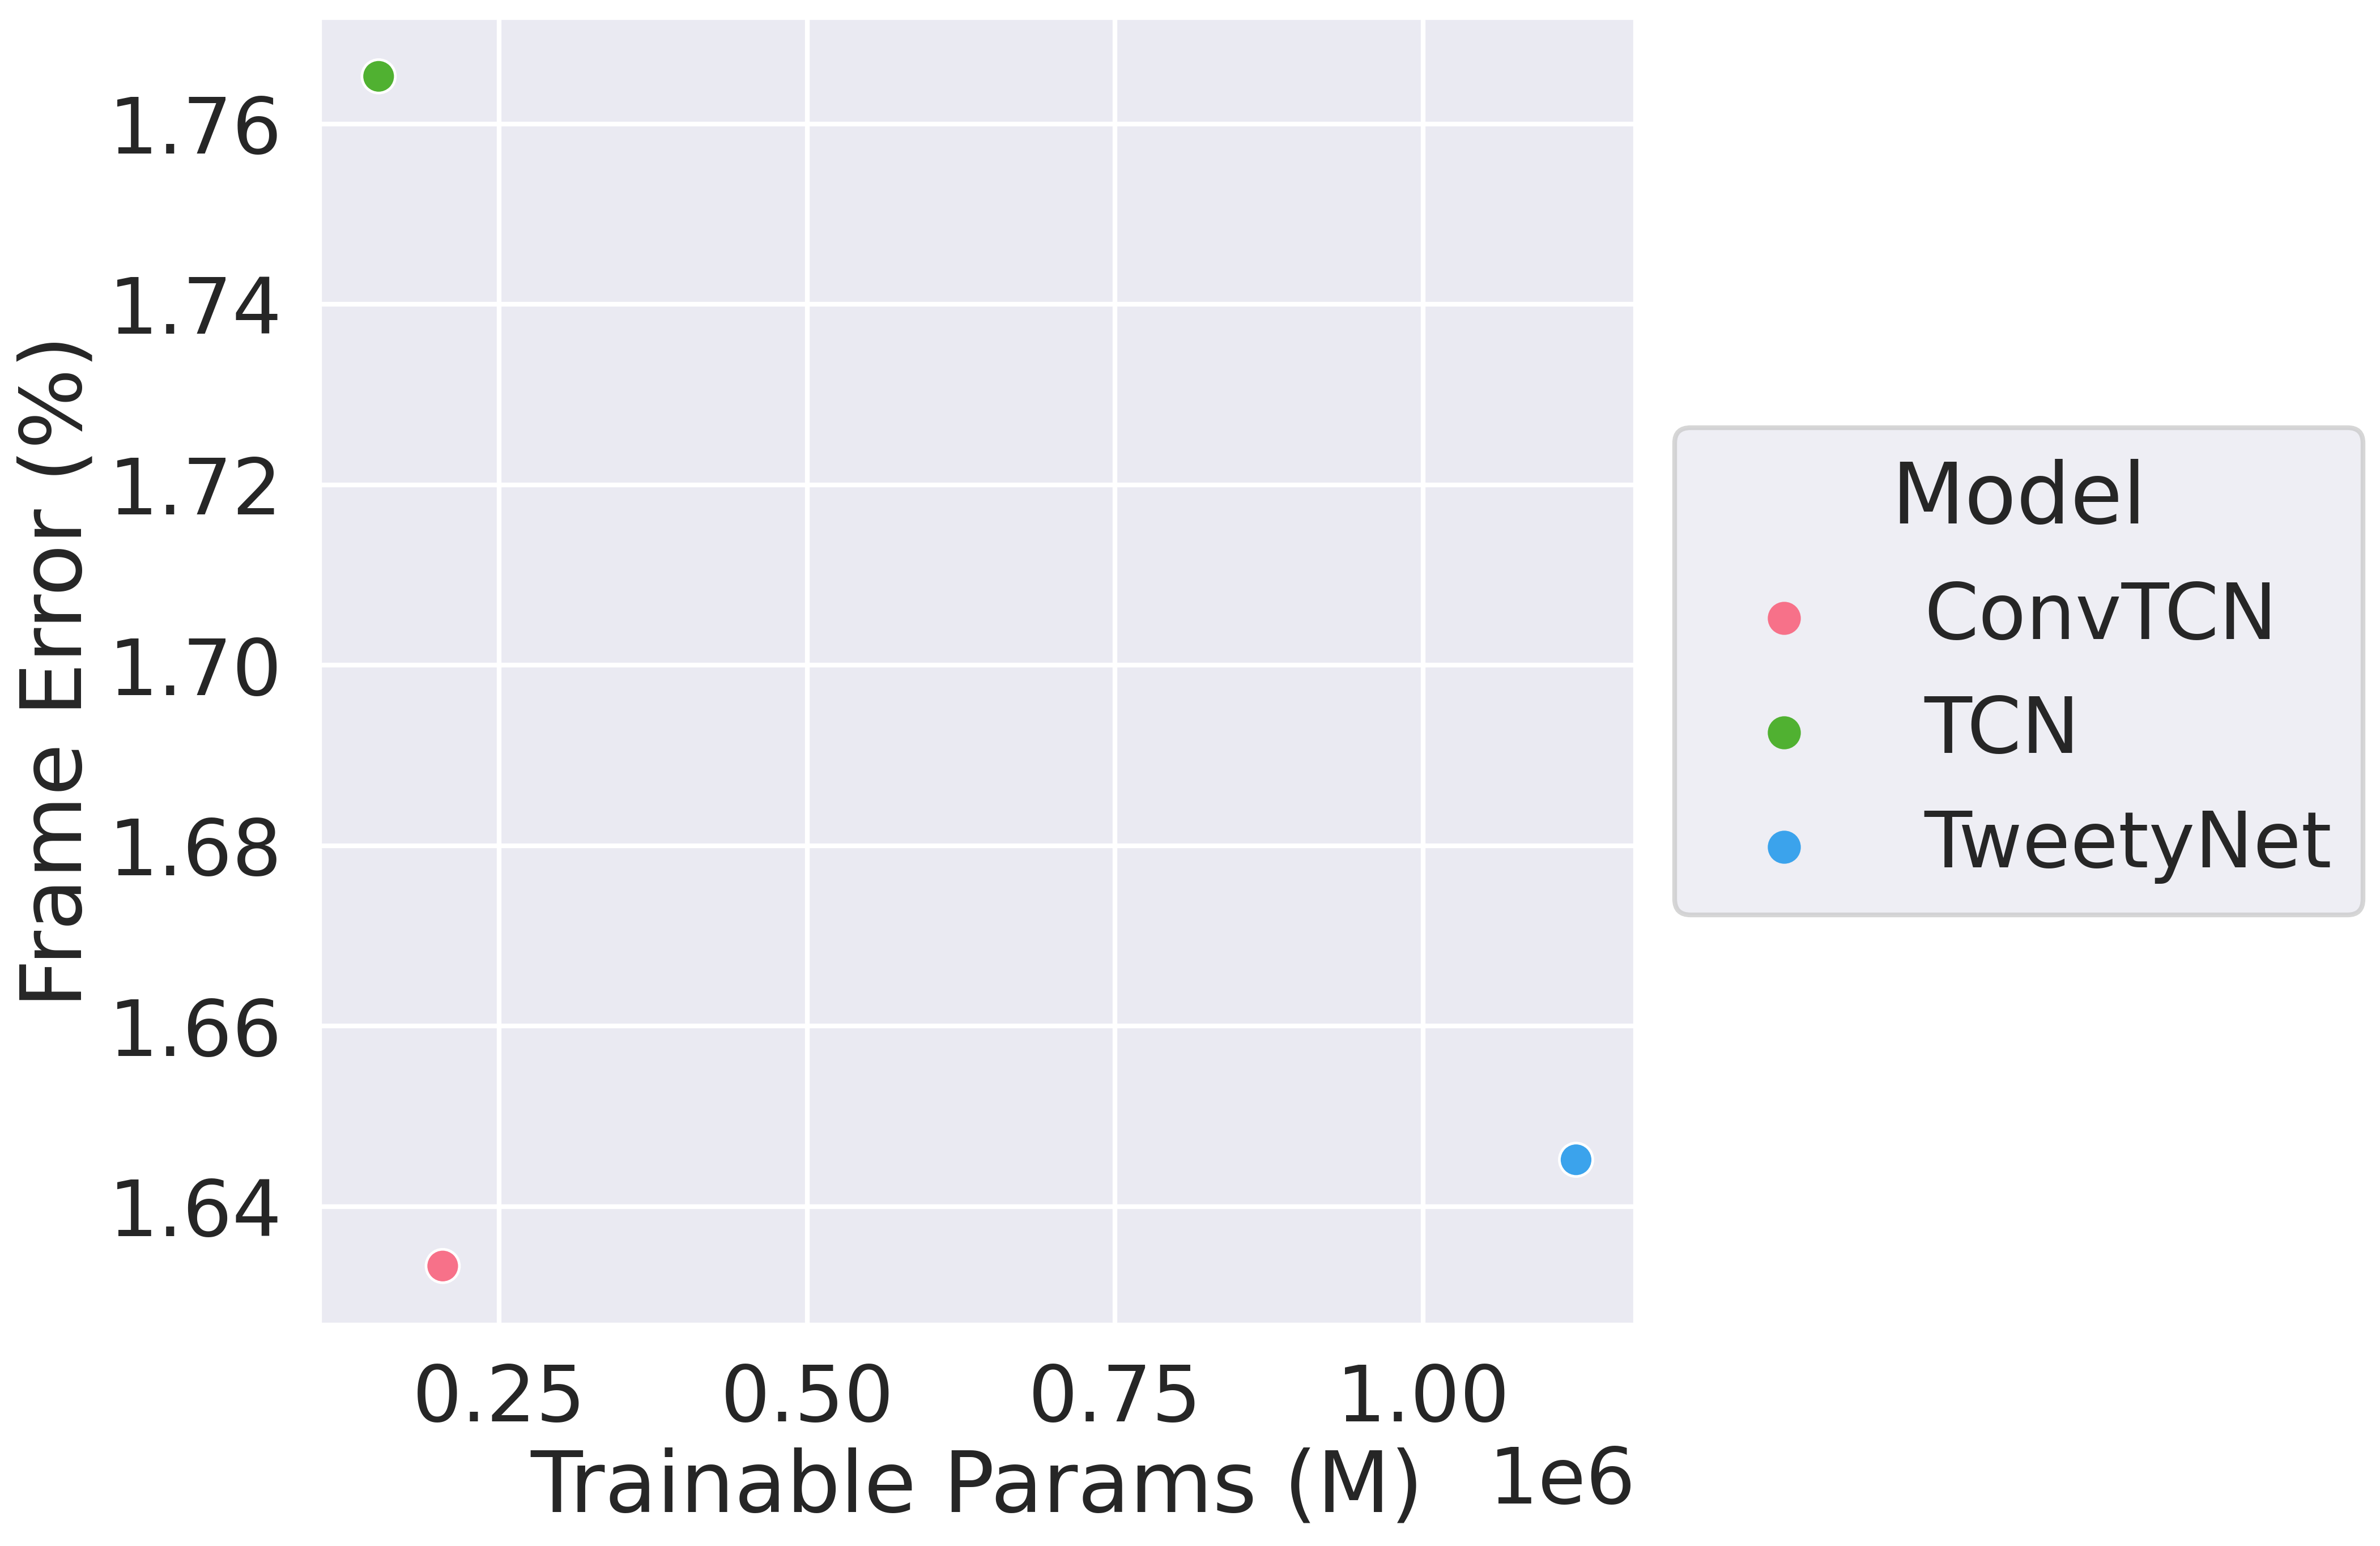

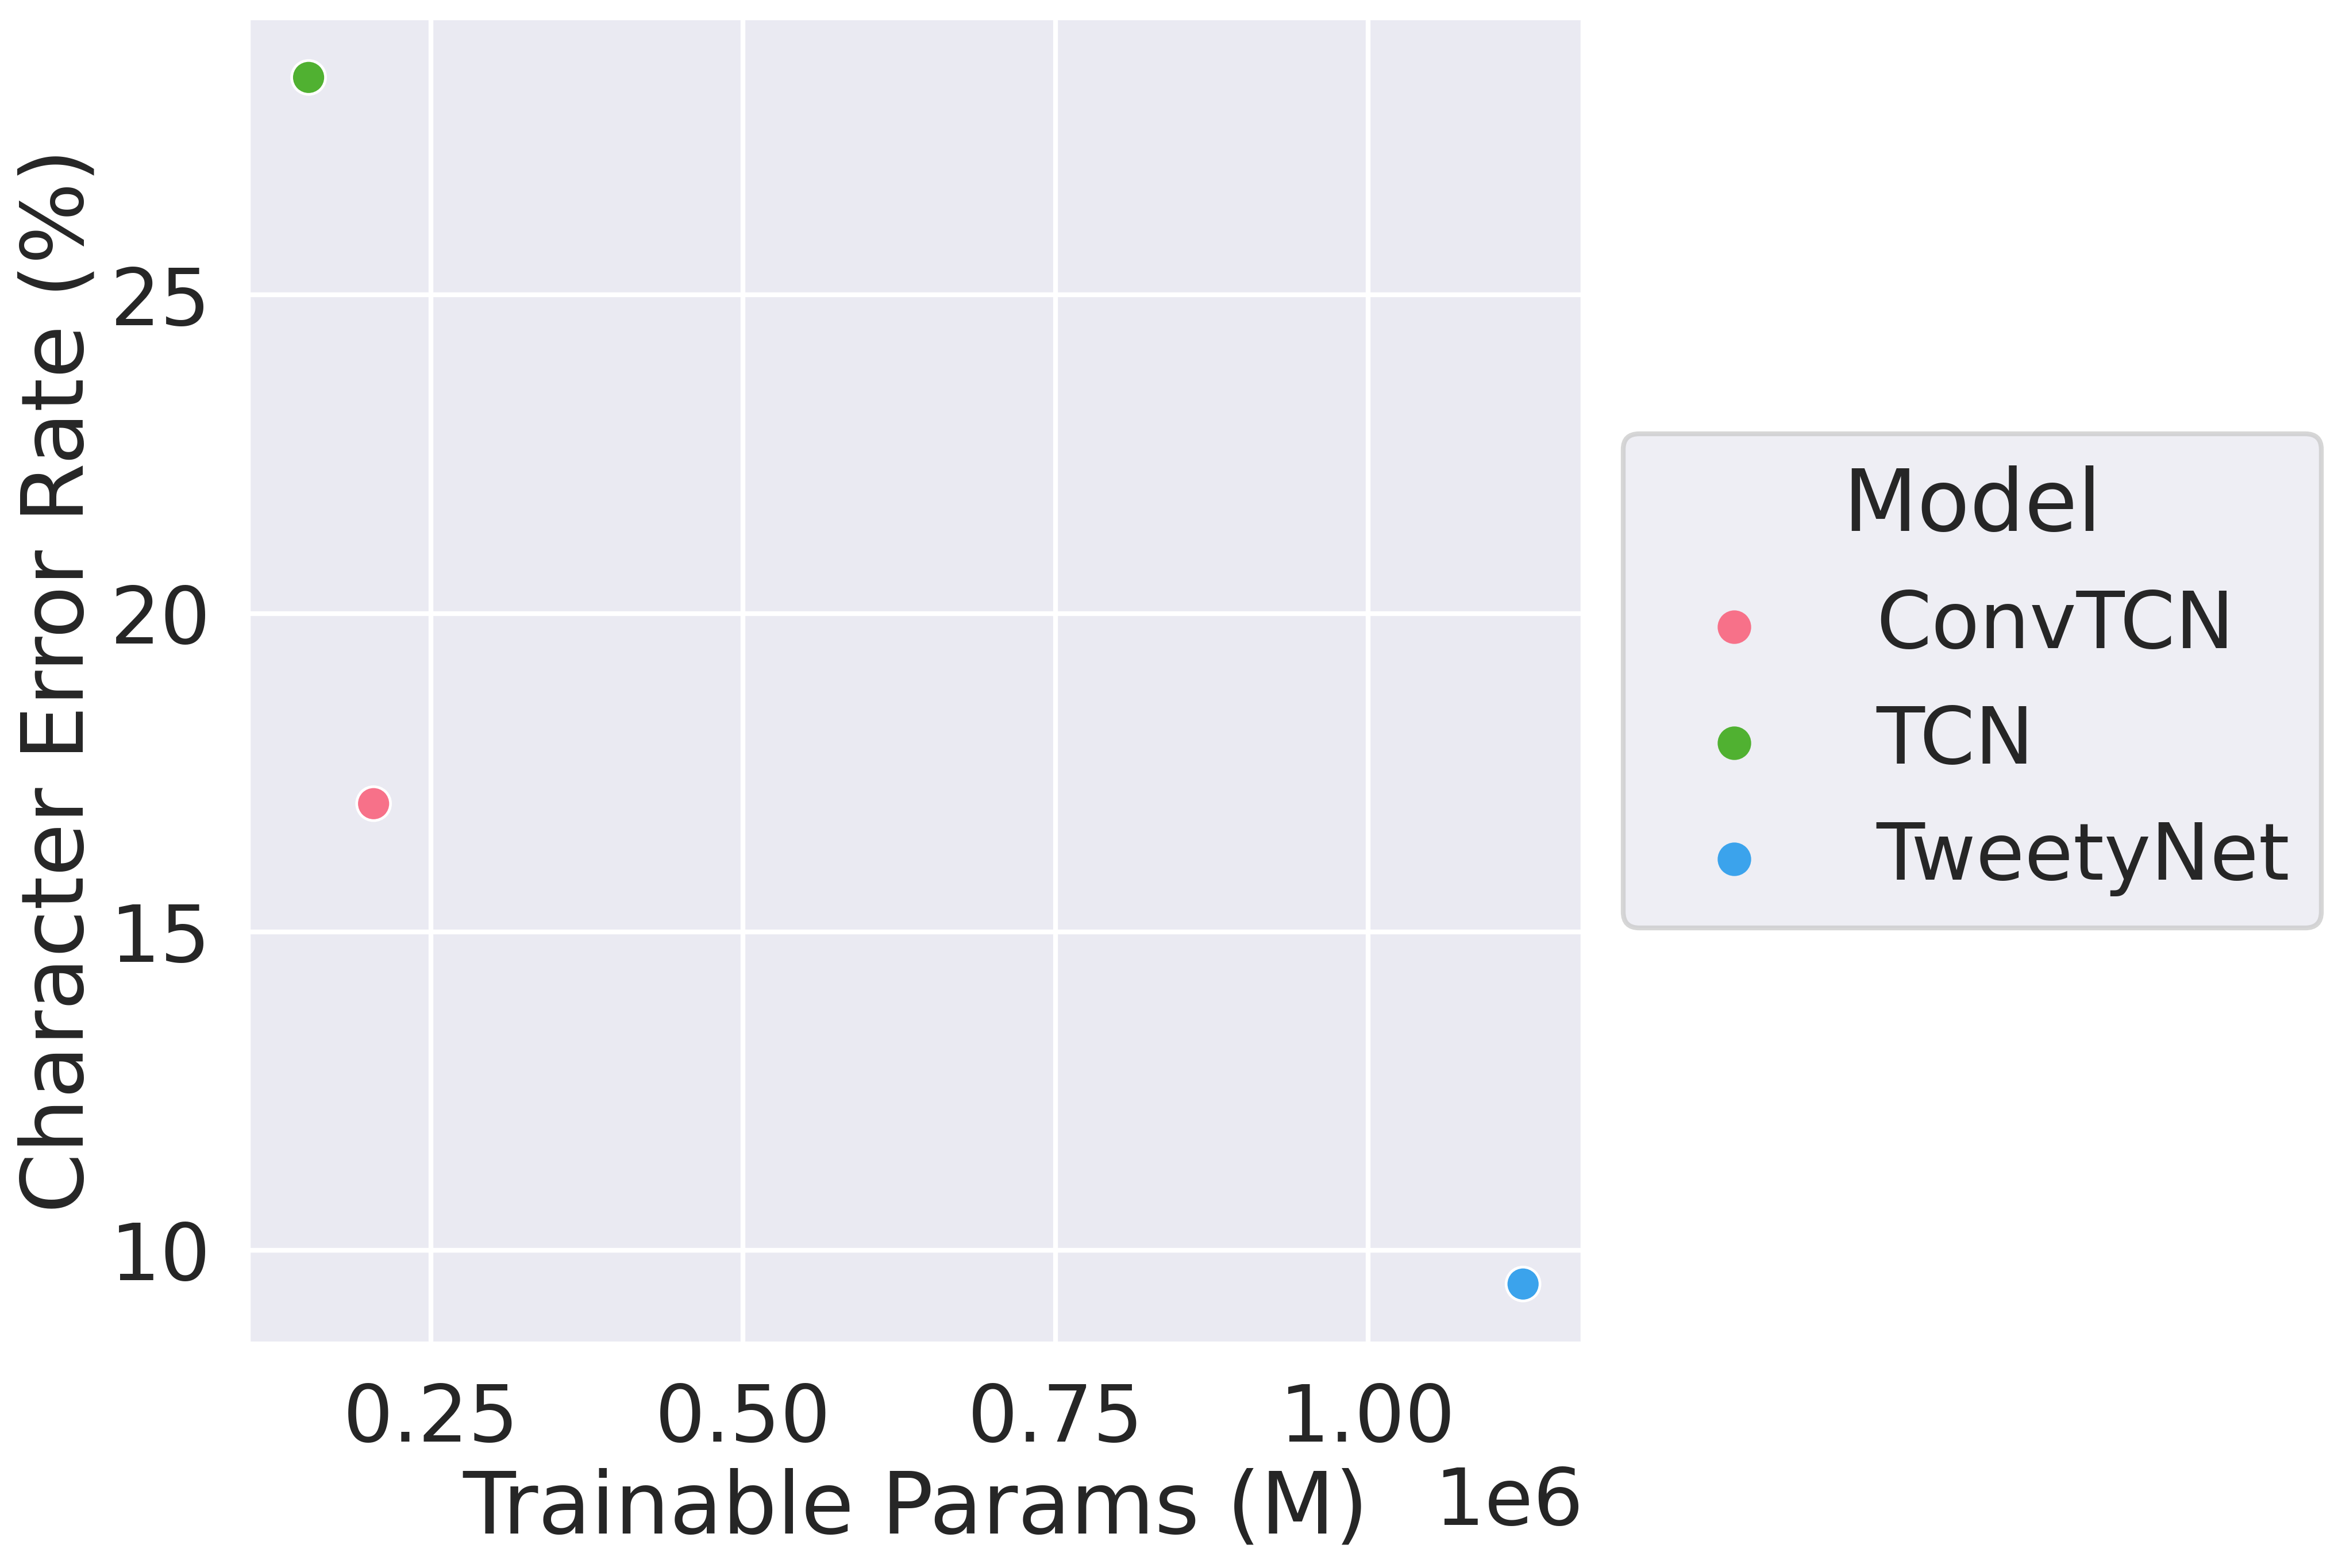

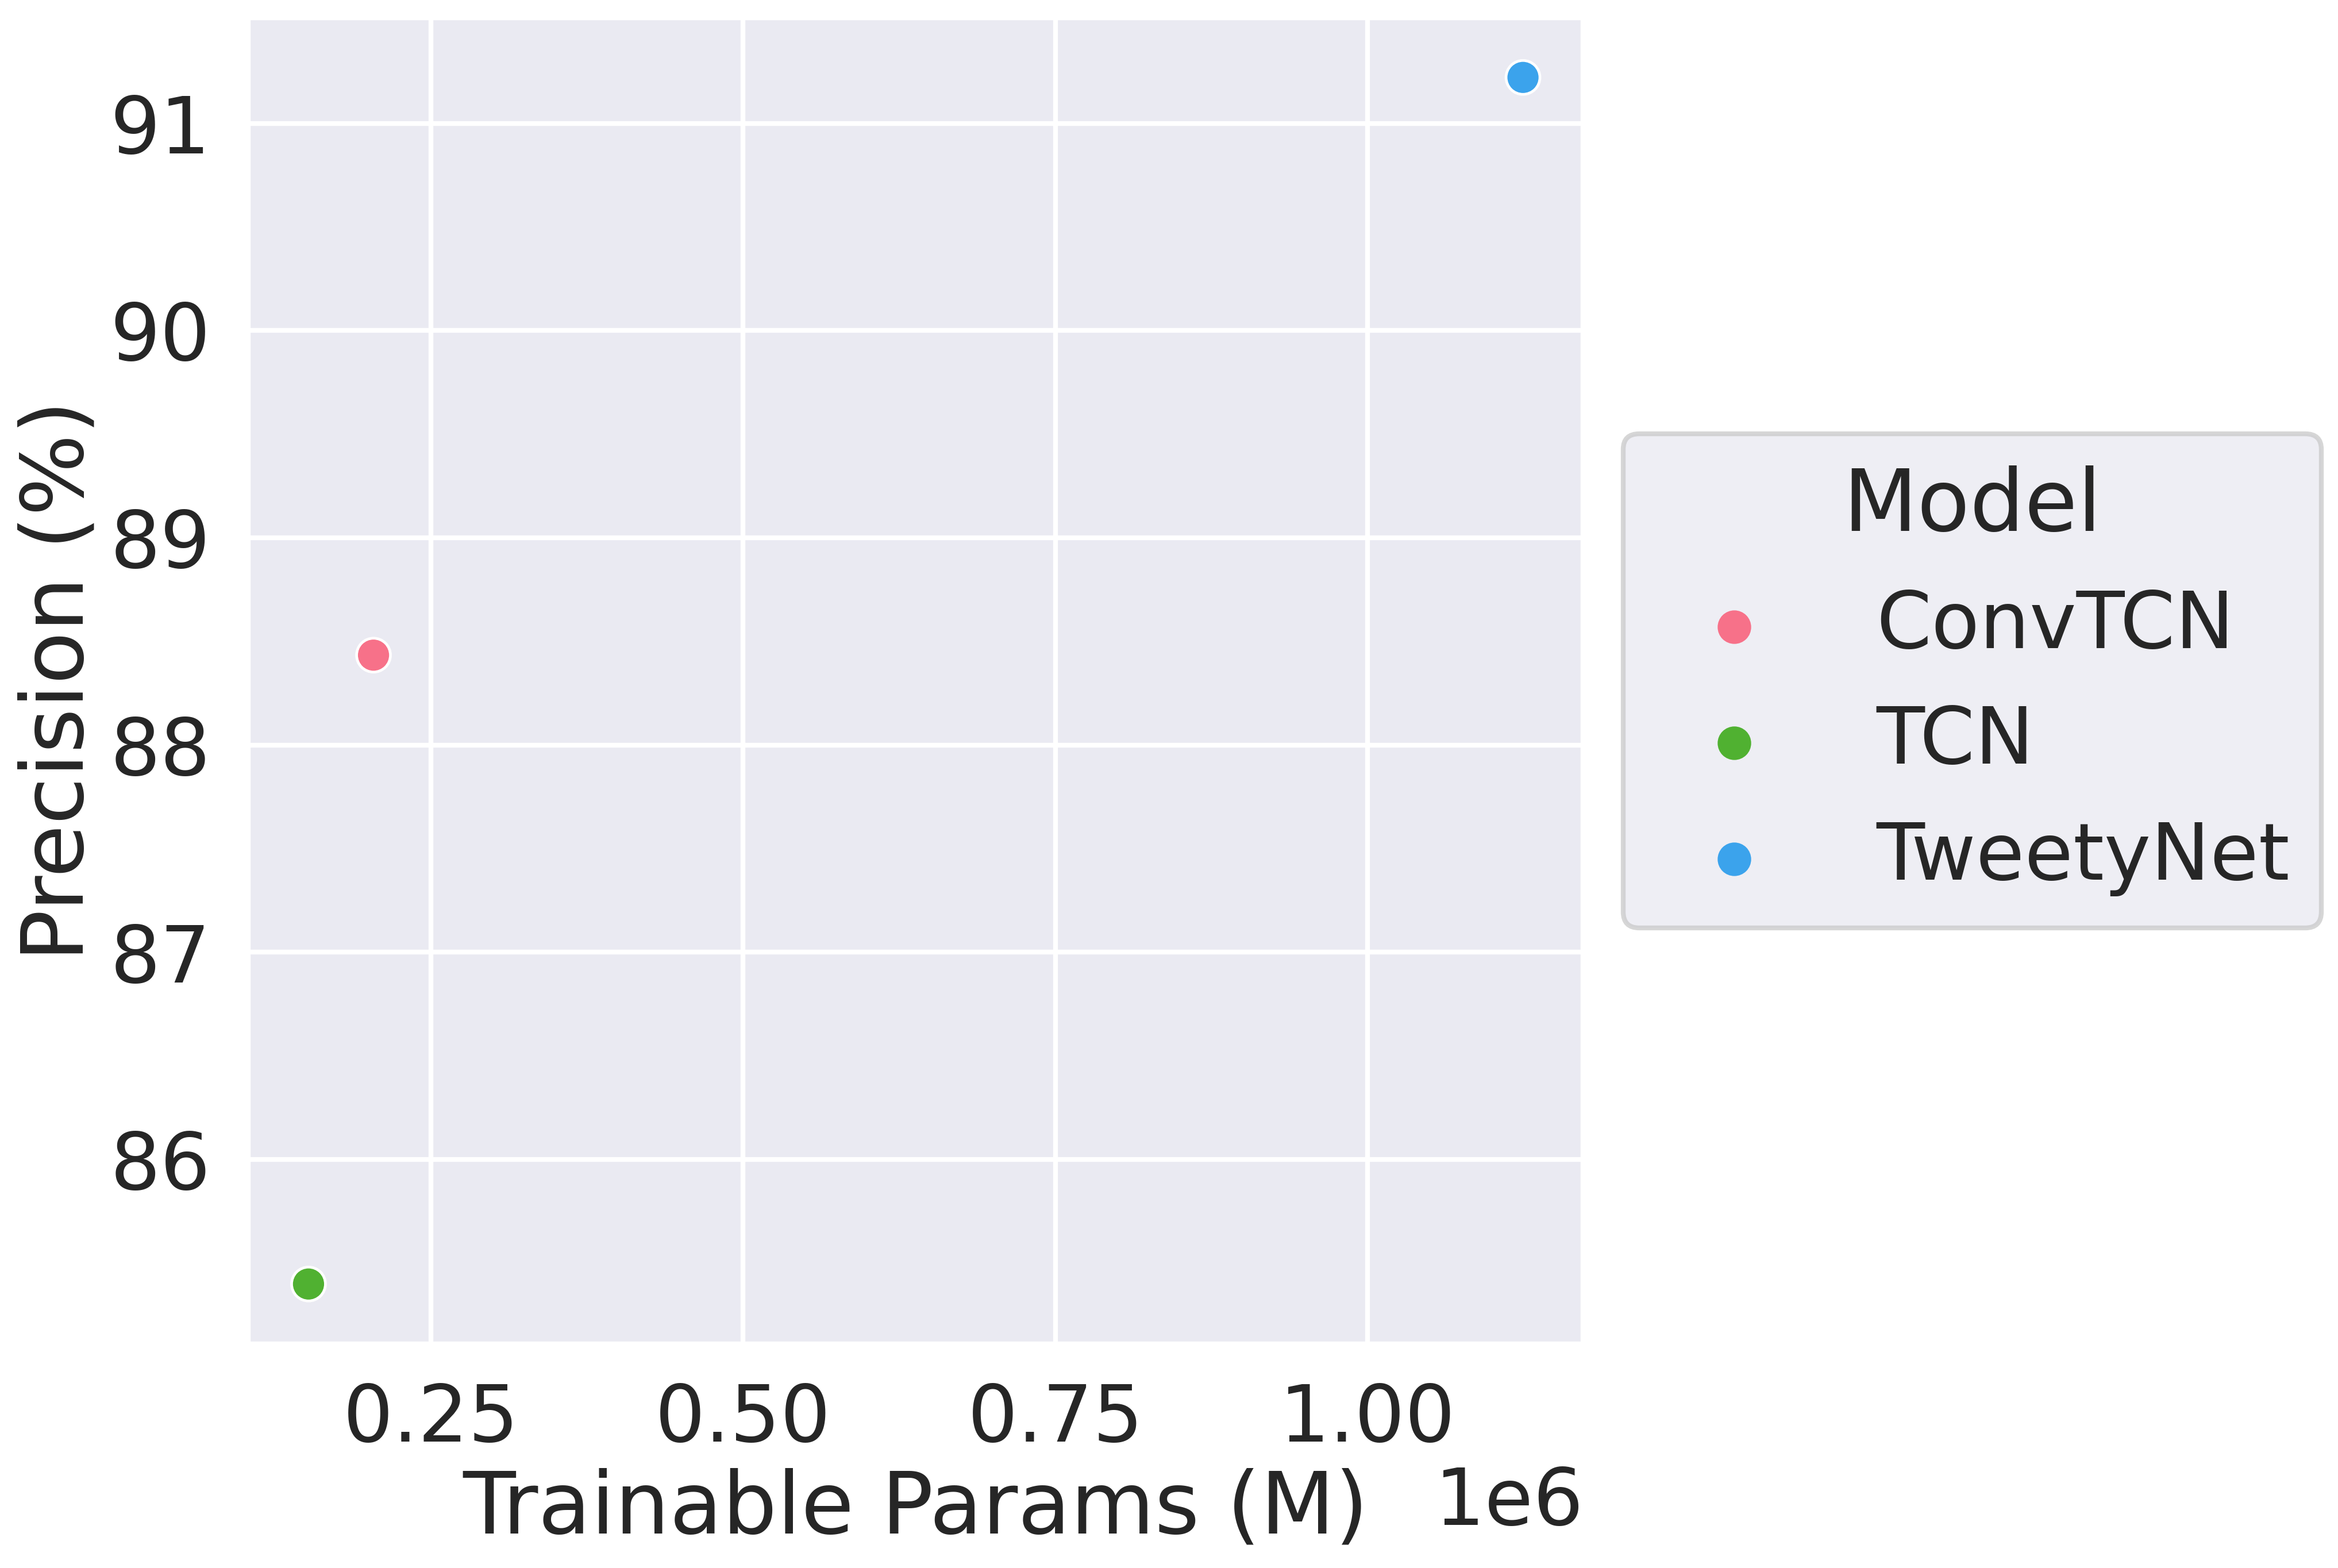

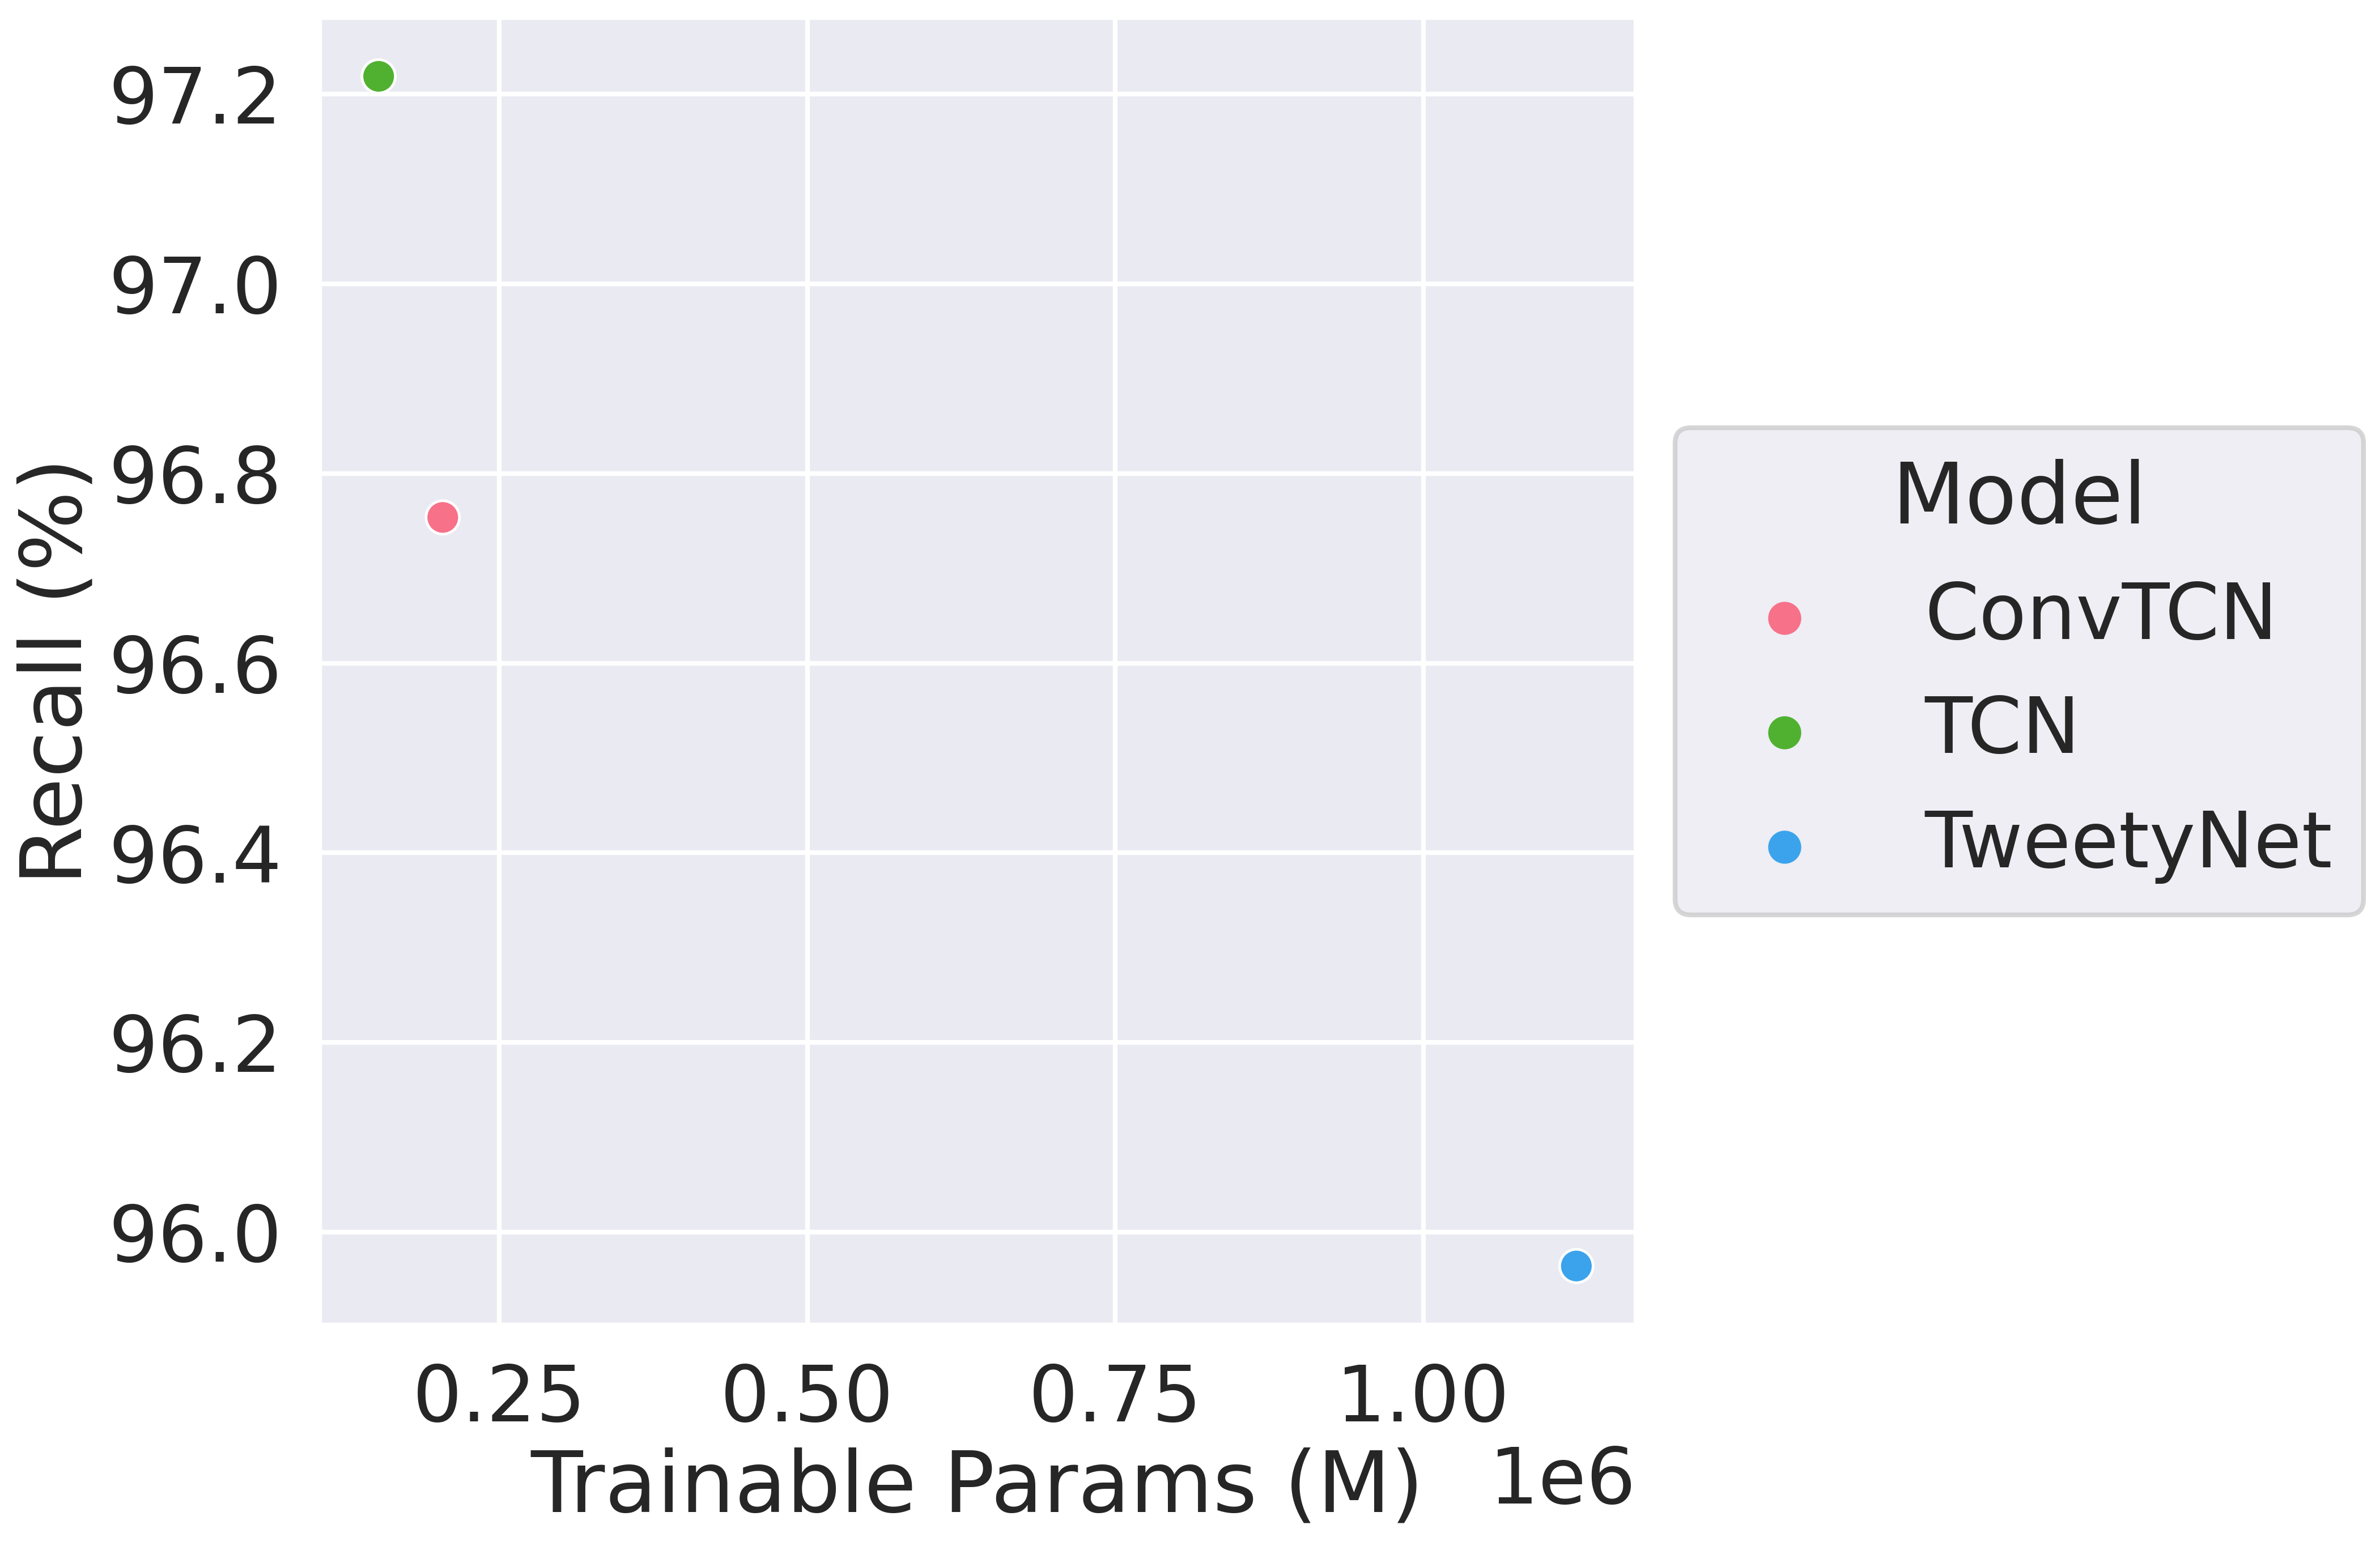

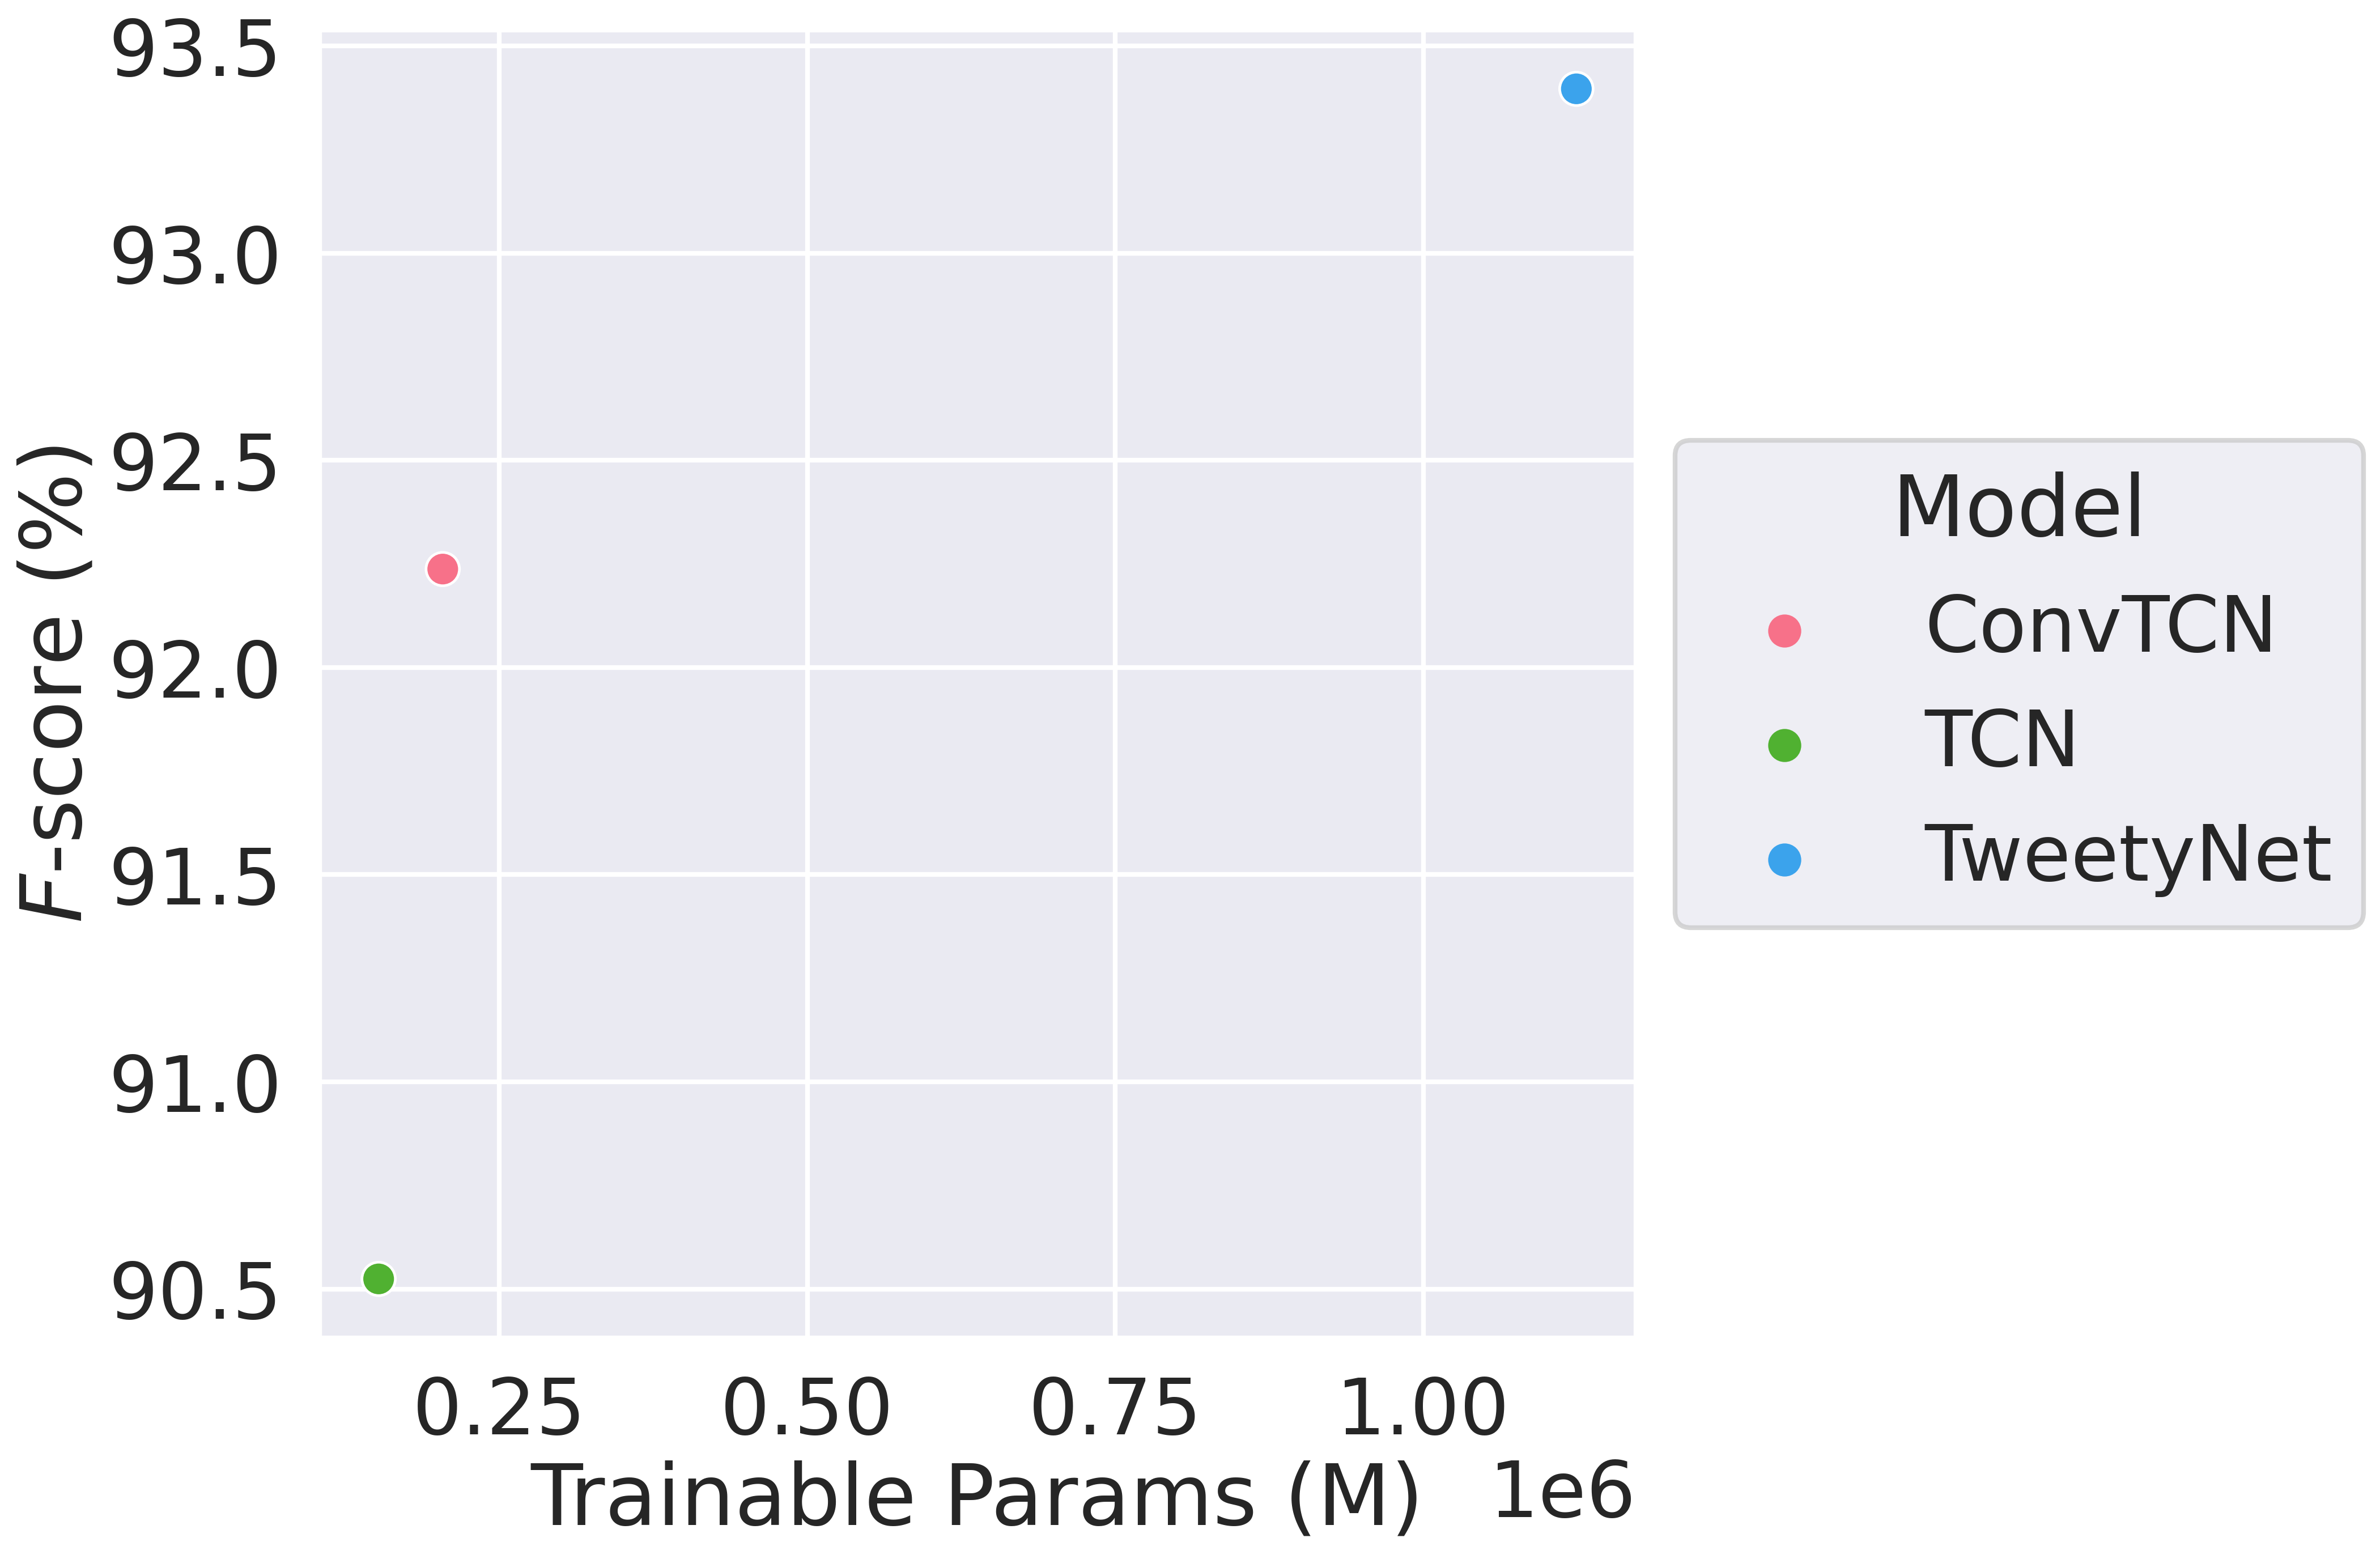

In [15]:
for metrics_plot_num, metrics_plot in enumerate(metrics_plots):
    data_metric = data[data['Metric'] == metrics_plot.metric]
    gb = data_metric.groupby(by=['Model', 'Trainable Params (M)', 'Post-processing']).agg(
        mean=pd.NamedAgg("value", "mean"),
        std=pd.NamedAgg("value", "std"),
    ).reset_index()
    gb['Model'] = gb['Model'].map(lambda x: x.replace('TemporalConvNet', 'TCN'))

    fig, ax = plt.subplots(figsize=(10,10), dpi=300)
    data_plot = gb[gb['Post-processing'] == False]
    g = sns.scatterplot(
        data=data_plot,
        x='Trainable Params (M)',
        y='mean',
        ax=ax,
        hue='Model',
        palette="husl",
        s=200,
    )
    sns.move_legend(g, loc='center left', bbox_to_anchor=[1.0, 0.5])
    g.set_ylabel(metrics_plot.metric)
    plt.savefig(f'doc/figures/{metrics_plot.save_fname}.svg', bbox_inches="tight")